# Maximum Likelihood (ML) and Maximum a Posteriori (MAP)

## implementation of necessary functions

In [1]:
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

np.random.seed(14)

# The gradient_descent implementation.
def gradient_descent(f, grad_f, X_tilda, w_init, y_noisy, kmax, tolf, tolx):
    
    # Initialization
    w = np.zeros((kmax, w_init.size))
    f_val = np.zeros((kmax, 1))
    grads = np.zeros((kmax, w_init.size))
    err = np.zeros((kmax, 1))
    
    # Assign the values for the first iteration
    w[0, :] = w_init
    f_val[0] = f(X_tilda, w[0, :], y_noisy)
    grads[0, :] = grad_f(X_tilda, w[0, :], y_noisy)
    err[0] = np.linalg.norm(grads[0, :], ord=2)
    
    # Choose step size
    alpha = 0.1
    
    # Handle the condition for the first iteration
    # if k = 0 then w[k-1, :] = w[-1, :]
    w[-1, :] = np.ones((w_init.size,))
    
    # Start the iterations
    k = 0
    while (k < kmax-1 and
          np.linalg.norm(grads[k, :], ord=2) > tolf * np.linalg.norm(grads[k-1, :], ord=2) and
          np.linalg.norm((w[k, :]-w[k-1, :]), ord=2) > tolx):
        
        k = k + 1
        
        # Update the step size alpha
        alpha = backtracking(f, grad_f, X_tilda, w[k, :], y_noisy)
        
        # Update the value of x
        w[k, :] = w[k-1, :] - alpha * grads[k-1, :]
        
        # Update the values the the actual iteration
        f_val[k] = f(X_tilda, w[k, :], y_noisy)
        grads[k, :] = grad_f(X_tilda, w[k, :], y_noisy)
        err[k] = np.linalg.norm(grads[k, :], ord=2)
        
        
    
    # Truncate the vectors that are (eventually) too long
    f_val = f_val[:k+1]
    grads = grads[:k+1,:]
    err = err[:k+1]
    w = w[:k+1,:]
    return w, k, f_val, grads, err

# modified backtracking
def backtracking(f, grad_f, X_tilda, w, y_noisy):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(X_tilda, (w - alpha * grad_f(X_tilda, w, y_noisy)), y_noisy) > f(X_tilda, w, y_noisy) - c * alpha * np.linalg.norm(grad_f(X_tilda, w, y_noisy), 2) ** 2:
        alpha = tau * alpha
        # next line prevent alpha to go extremely low
        if alpha < 1e-5:
            break
    return alpha

## creation of dataset

In [2]:
# create a N x n+1 Vandermode matrix
n = 3   # the true degree of polynomial
N =  20 # number of samples

# input
x = np.linspace(0, 1, N)

# vandermonde creation
X = np.vander(x, n)

# true weights
w_true = np.ones((n,))

# outputs
y_true = X @ w_true

# add normal noise (mean=0, std=0.1)
y_noisy = y_true + np.random.normal(0, 0.1, y_true.shape)

## Maximum Likelihood Estimation (MLE)

It is known that the Maximum Likelihood (ML) approach works by defining the conditional probability of observing D given w, p(D|w) and then optimizes the parameters w to maximize this **probability distribution** over D. Moreover, it is also known that this approach can be made equivalent to the **deterministic** approach to solve such problems (the Least Square method) by taking the negative-log of p(D|w).  
  
**Note :**  
suppose don't have the true degree of n which is most of the case.  
By changing n_tilda, we actually **change MODEL** to predict the output not the DATA --->   try different n from small to large values

Text(0.5, 1.0, 'ML estimation')

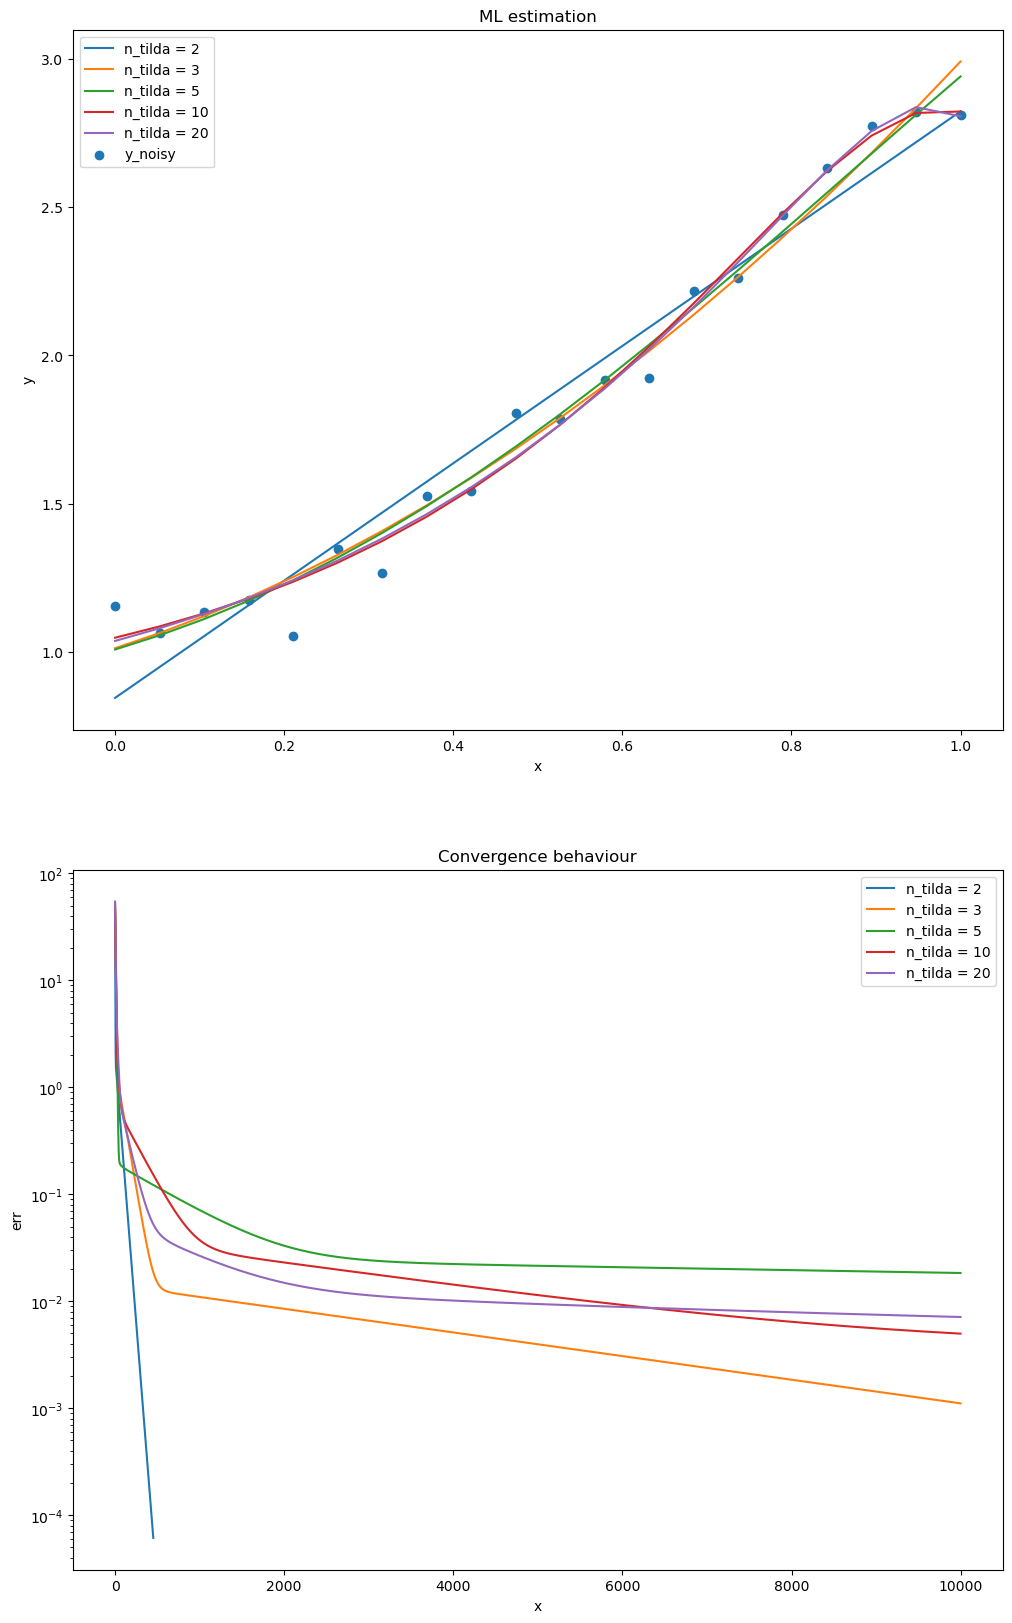

In [4]:
# optimization function
def f(X_tilda, w, y_noisy):
    return 0.5 * np.linalg.norm((X_tilda @ w - y_noisy), ord=2) ** 2

# optimization function gradient
def grad_f(X_tilda, w, y_noisy):
    return  X_tilda.T @ (X_tilda @ w - y_noisy) 

# stopping condition
kmax = 10000
tolf = 1e-6
tolx = 1e-6

# we suppose we don't have the true degree of n which is usual
legends = list()
n_tildas_value = [2,3,5,10,20]

# open a figure to plot schemes
fig,axes = plt.subplots(2,1,figsize=(12,20))

for n_tilda in n_tildas_value:
    X_tilda = np.vander(x, n_tilda)

    w0 = np.zeros((n_tilda, ))

    w, k, f_val, grads, err = gradient_descent(f, grad_f, X_tilda, w0, y_noisy, kmax, tolf, tolx)

    y_est = X_tilda @ w[k, :]

    legends.append(f'n_tilda = {n_tilda}')
    axes[0].plot(x, y_est)
    axes[1].plot(err)

axes[1].legend(legends)
axes[1].set_xlabel('x')
axes[1].set_ylabel('err')
axes[1].set_title('Convergence behaviour')
axes[1].set_yscale('log')

legends.append(f'y_noisy')
axes[0].scatter(x, y_noisy)
axes[0].legend(legends)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('ML estimation')

# plt.suptitle('MLE')
# if(w[-1].shape == w_true.shape):
#     print(f'W estimation Error = {np.linalg.norm(w[-1]-w_true)/ np.linalg.norm(w_true)}')


### observation
##### Looking at ML estimation plot we can say that:  
1- n_tilda = 2  MLE act as linear regression and estimate the dataset wtih straight line (because of n_tilda = 2)  
2- n_tilda = 3  which is the true value of n results in a good approximation  
3- n_tilda = 5  still results in a good approximation however n_tilda is bigger than n  
4- n_tilda = 10 and 20 overestimate the data and as we can see it goes low at the end (because of the overestimation)  
  
##### Looking at error plot we can say that:  
1- n = 2 reults in the smallest error and n = 5 is the largest  
2- it should notice that the smallest error doesn't necessarly mean the best solution, it can also mean (for ex.) overestimation  
3- see for n_tilda around the true value of n we obtain good approximation but if n_tilda >> n it results in overestimation

## Maximum a Posteriori (MAP):
  
MLE is **sensative to conditioning** of the problem. It also can **overestimate** the data and act just like *Empirical Risk Minimization* without regularization parameter.  
  
When the problem is ill-conditioned, it is usually difficult to optimize due to algorithmic instabilities. When this happens, it is usual to use the **Maximum A Posteriori** approach, that insert additional prior information about the distribution of the weights w to the probabilistic model to improve the obtained results.  
  
**Remeber** MAP uses prior knowledge on the parameter in order to avoid overestimation problem. For a given prior after observing some data we should update the parameter (theta) distribution. This is were *Bayes theorem* shows up. (we suppose that the weights are normally distributed)


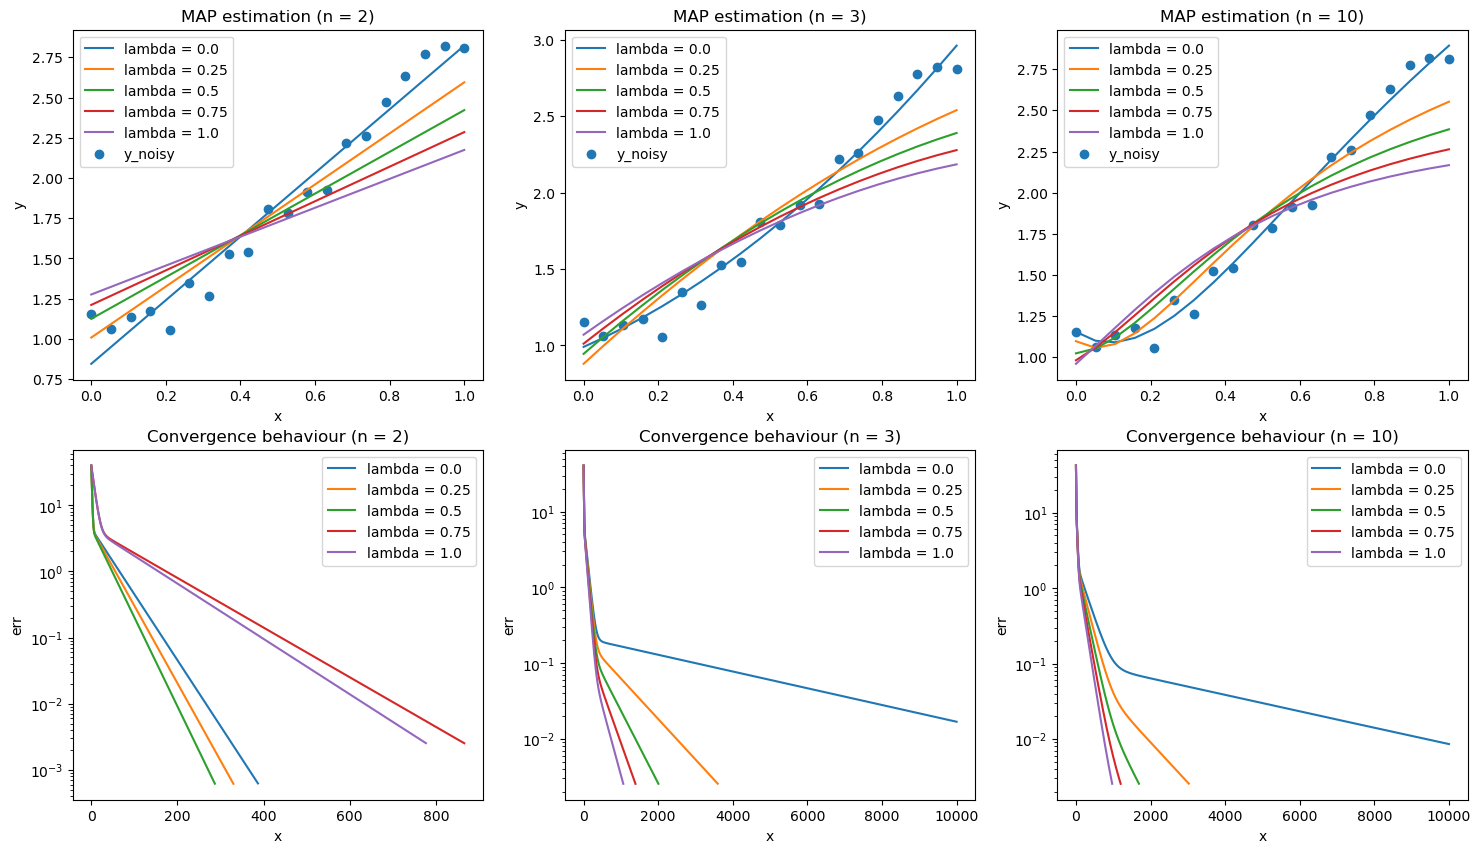

In [5]:
# optimization function
def f(X_tilda, w, y_noisy ):
    return (0.5 * np.linalg.norm((X_tilda @ w - y_noisy), ord=2) ** 2)  + (0.5 * lambd * np.linalg.norm(w) ** 2)
    #                   maximmum likelihood                                 regularization(prior knowledge)

# optimization function gradient
def grad_f(X_tilda, w, y_noisy):
    return  X_tilda.T @ (X_tilda @ w - y_noisy) +  lambd * w.T 

# stopping condition
kmax = 10000
tolf = 1e-6
tolx = 1e-5

# we suppose we don't have the true degree of n which is usual
n_tildas_value = [2,3,10]
lambdas_value = np.linspace(0,1,5)

# open a figure to plot schemes
fig,axes = plt.subplots(2,3,figsize=(18,10))

for i, n_tilda in enumerate(n_tildas_value):
    
    legends = list()
    X_tilda = np.flip(np.vander(x, n_tilda))
    w0 = np.zeros((n_tilda, ))
    
    for lambd in lambdas_value:

        w, k, f_val, grads, err = gradient_descent(f, grad_f, X_tilda, w0, y_noisy, kmax, tolf, tolx)
        y_est = X_tilda @ w[k, :]

        legends.append(f'lambda = {lambd}')
        axes[0,i].plot(x, y_est)
        axes[1,i].plot(err)

    axes[1,i].legend(legends)
    axes[1,i].set_xlabel('x')
    axes[1,i].set_ylabel('err')
    axes[1,i].set_title(f'Convergence behaviour (n = {n_tilda})')
    axes[1,i].set_yscale('log')

    legends.append(f'y_noisy')
    axes[0,i].scatter(x, y_noisy)
    axes[0,i].legend(legends)
    axes[0,i].set_xlabel('x')
    axes[0,i].set_ylabel('y')
    axes[0,i].set_title(f'MAP estimation (n = {n_tilda})')

# plt.suptitle('MLE')
# if(w[-1].shape == w_true.shape):
#     print(f'W estimation Error = {np.linalg.norm(w[-1]-w_true)/ np.linalg.norm(w_true)}')


### observation
##### Looking at MAP estimation plot we can say that:  
1- it can see that when we choose lambda = 0 the algorithm is the same as MLE and in this case for big n_tilda the algorithm doesn't work well  
2- for lambda != 0 the MAP algorithm works very well even for big n_tilda and the reason is because of the regularization parameter that lambda provide in order to avoid overestimation and compensate ill-conditionning  
  
##### Looking at error plot we can say that:  
1- for n_tilda equal or greater than n, the larger the lambda is the smaller error we obtain  
2- for n_tilda smaler than n, the smaller the lambda is the smaller error we obtain

## comparison between MLE and MAP (lambda=1)

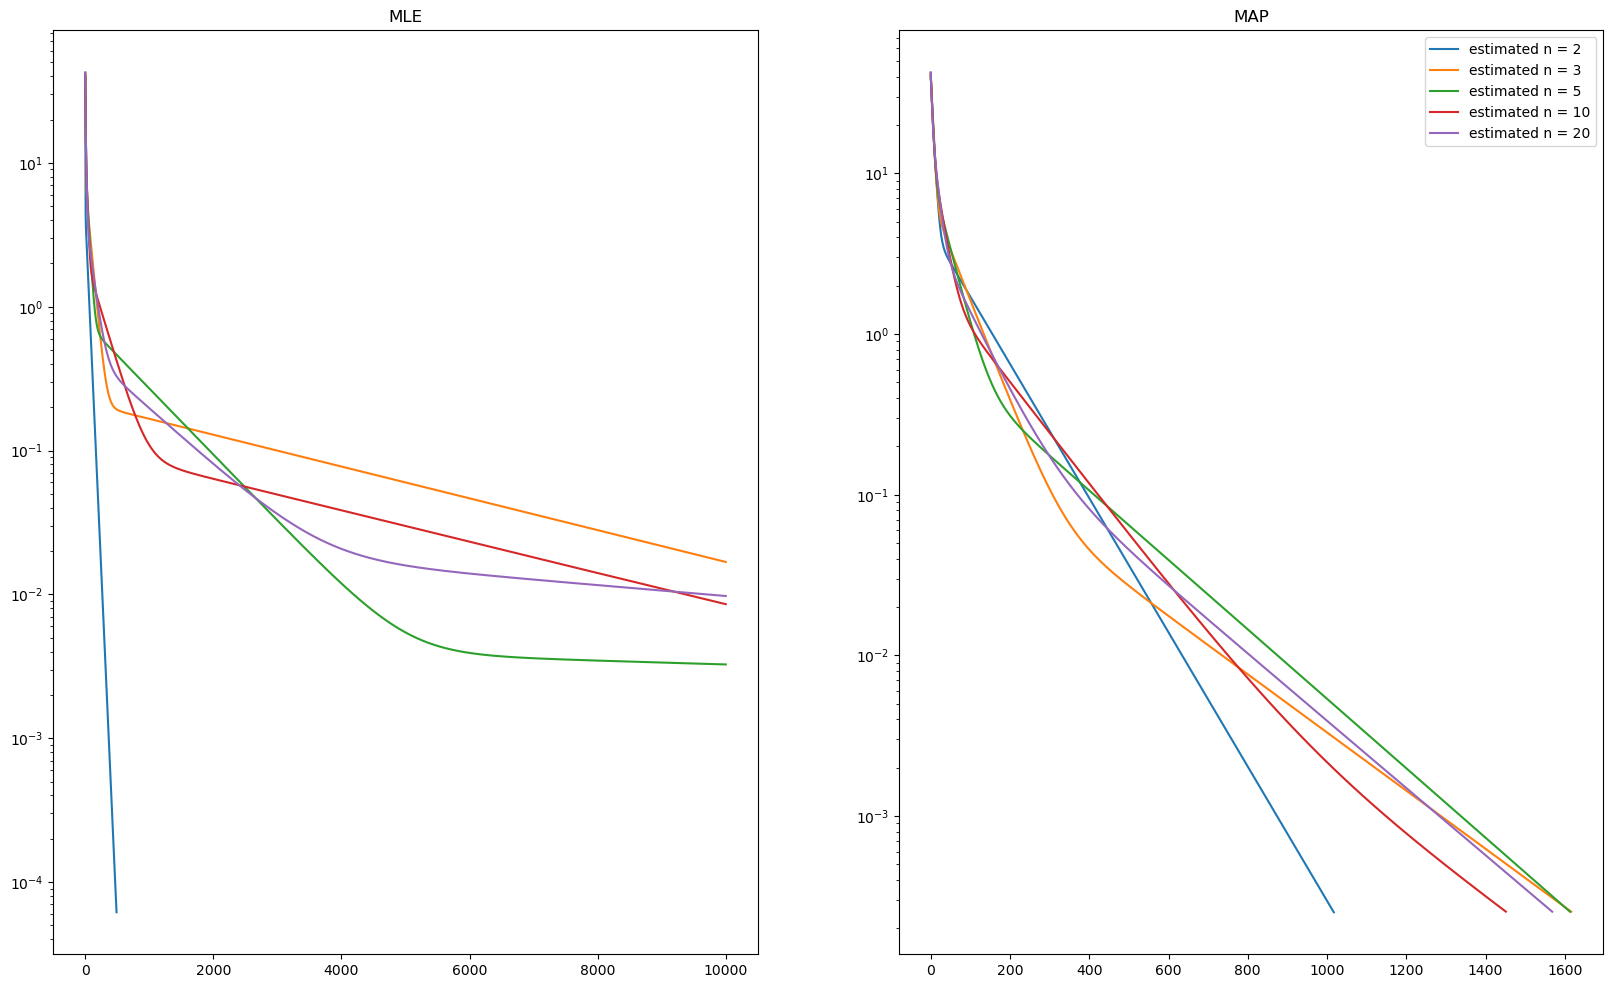

In [6]:
tildes = [2,3,5,10,20]
fig, axes = plt.subplots(1,2,figsize=(20,12))
legends = []

kmax = 10000
tolf = 1e-6
tolx = 1e-6

lambd = 1

for i, ax in enumerate(axes):
    if i == 1:
        def f(X_tilda, w, y_noisy ):
            return 0.5 * np.linalg.norm((X_tilda @ w - y_noisy), ord=2) ** 2  + lambd * 0.5 * np.linalg.norm(w) ** 2
        def grad_f(X_tilda, w, y_noisy):
            return  X_tilda.T @ (X_tilda @ w - y_noisy) +  lambd * w.T 
        ax.set_title('MAP')
        
    else:
        def f(X_tilda, w, y_noisy):
            return 0.5 * np.linalg.norm((X_tilda @ w - y_noisy), ord=2) ** 2
        def grad_f(X_tilda, w, y_noisy):
            return  X_tilda.T @ (X_tilda @ w - y_noisy) 
        ax.set_title('MLE')
        
    for n_tilde in tildes:
        X_tilda = np.flip(np.vander(x, n_tilde))
        w0 = np.zeros((n_tilde, ))

        w, k, f_val, grads, err = gradient_descent(f, grad_f, X_tilda, w0, y_noisy, kmax, tolf, tolx)

        y_est = X_tilda @ w[k, :]
        ax.plot(err)
        ax.set_yscale('log')
        legends.append(f'estimated n = {n_tilde}')
        
plt.legend(legends)
plt.show()

## Probabilistic Methods to Approximate Mathematical Constants


g = 3.1636


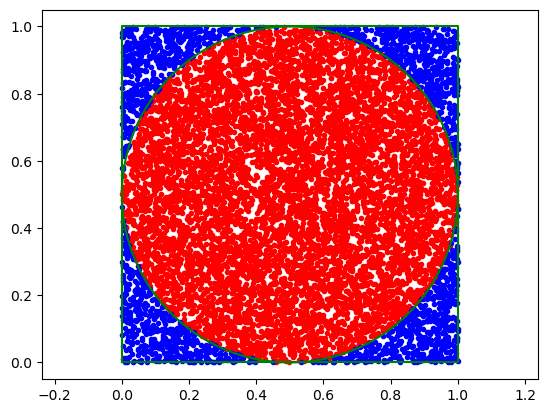

In [7]:
N_total = 10000  # number of points
l = 1           # square dimention
r = 0.5         # circle radius

c = np.array([[r],[r]])

# generate random points
p = np.random.rand(2,N_total)

# measure the points distance from the center
d  = np.linalg.norm(c-p,axis=0)

# count points in the circle
N_inter=sum(d<r)

g = (l**2/r**2) * (N_inter/N_total) * 1.00

plt.plot(p[0][d<r],p[1][d<r],'.r')
plt.plot(p[0][d>=r],p[1][d>=r],'.b')

theta=np.linspace(0,2*np.math.pi,100)
plt.plot(r+r*np.cos(theta),r+r*np.sin(theta),'g')
plt.plot([0,l,l,0,0],[0,0,l,l,0],'g')
plt.axis('equal')

print(f"g = {g}")